In [1]:
"""Cell 1: Generate grids and extract discontinuities."""

import sys
sys.path.insert(0, "..")

import numpy as np
import torch
import matplotlib.pyplot as plt
from data.data_processing import (
    get_nfv_dataset,
    preprocess_wavefront_data,
    _group_consecutive_diff_indices,
)

# Grid parameters
nx, nt = 50, 500
dx, dt = 0.02, 0.004
max_steps = 3

np.random.seed(42)
grids = get_nfv_dataset(
    n_samples=5, nx=nx, nt=nt, dx=dx, dt=dt,
    max_steps=max_steps, only_shocks=True,
)
processed = preprocess_wavefront_data(grids, nx, nt, dx, dt)

print(f"Generated {len(processed)} samples")

/Users/mchami/ETH/Thesis/saint-venant/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2it [00:00,  6.68it/s]                       

Generated 5 samples


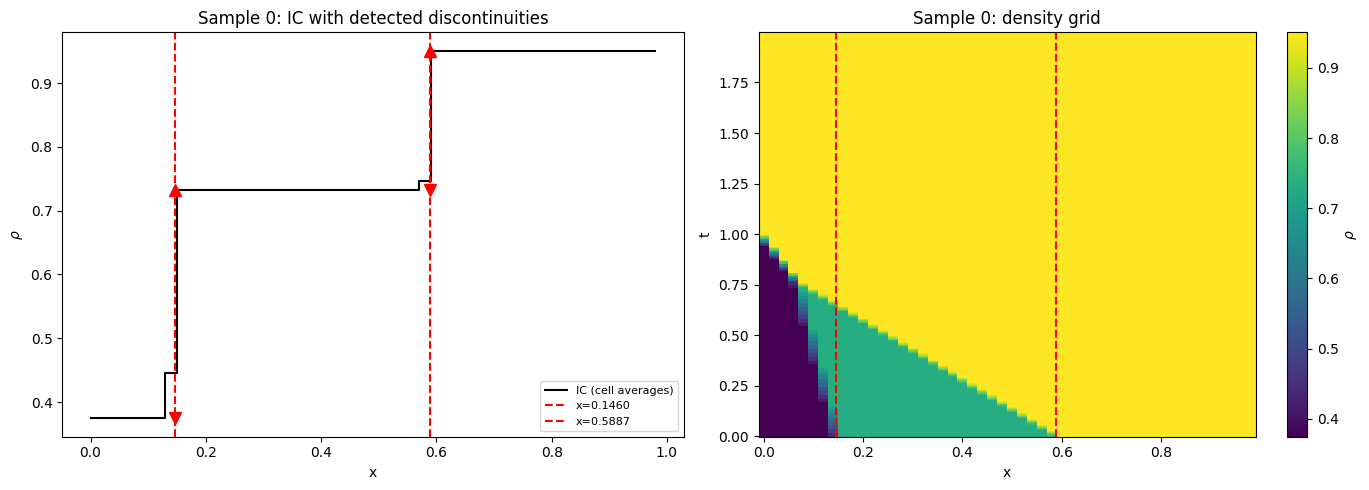

  disc 0: x=0.1460, left=0.3745, right=0.7320
  disc 1: x=0.5887, left=0.7320, right=0.9507


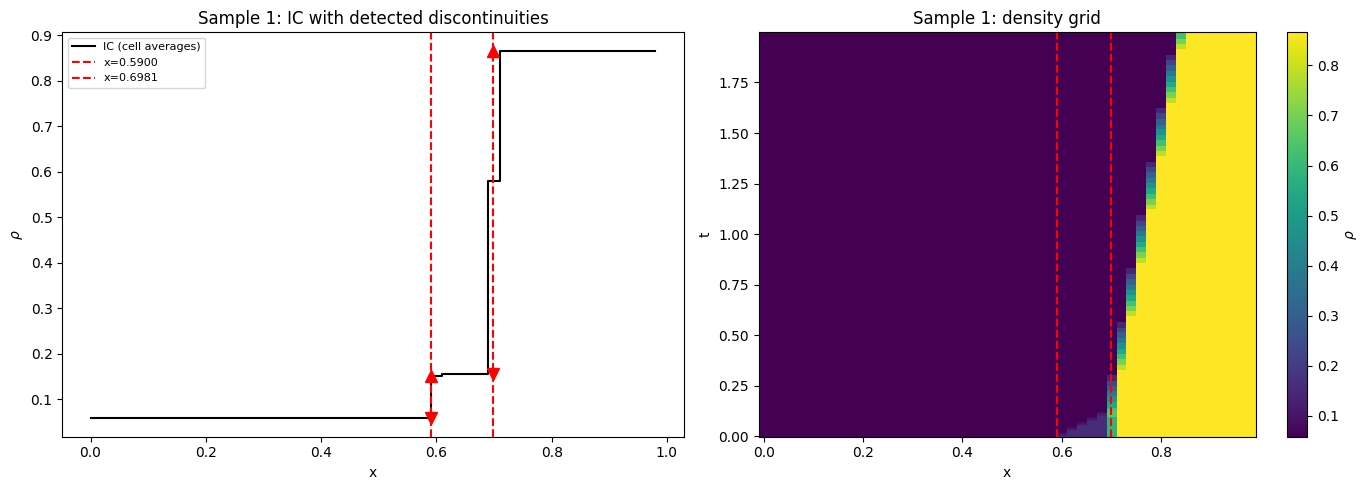

  disc 0: x=0.5900, left=0.0581, right=0.1505
  disc 1: x=0.6981, left=0.1560, right=0.8662


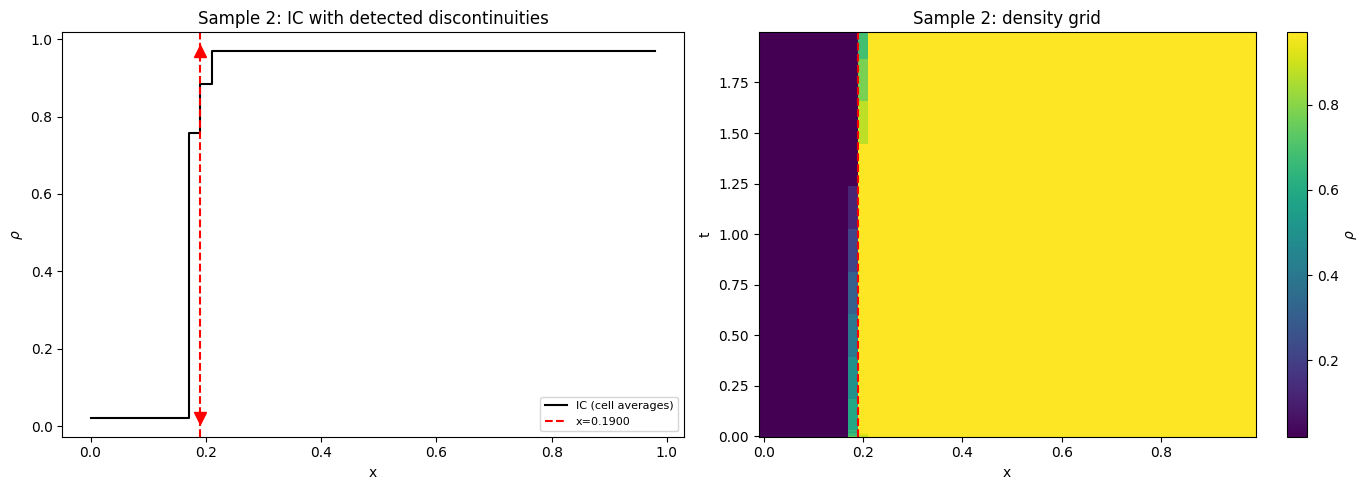

  disc 0: x=0.1900, left=0.0206, right=0.9699


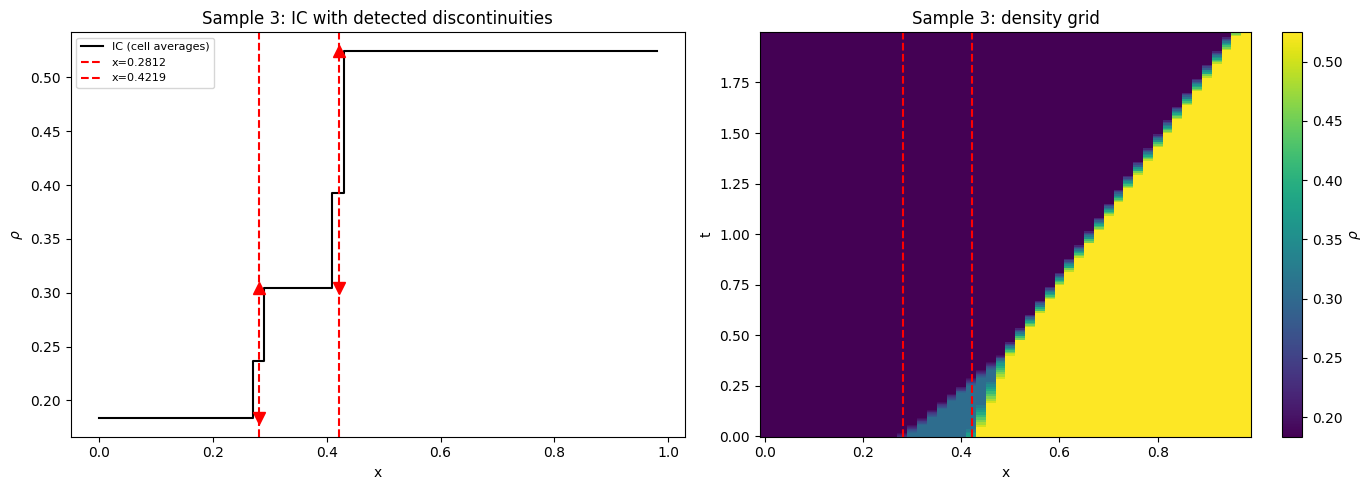

  disc 0: x=0.2812, left=0.1834, right=0.3042
  disc 1: x=0.4219, left=0.3042, right=0.5248


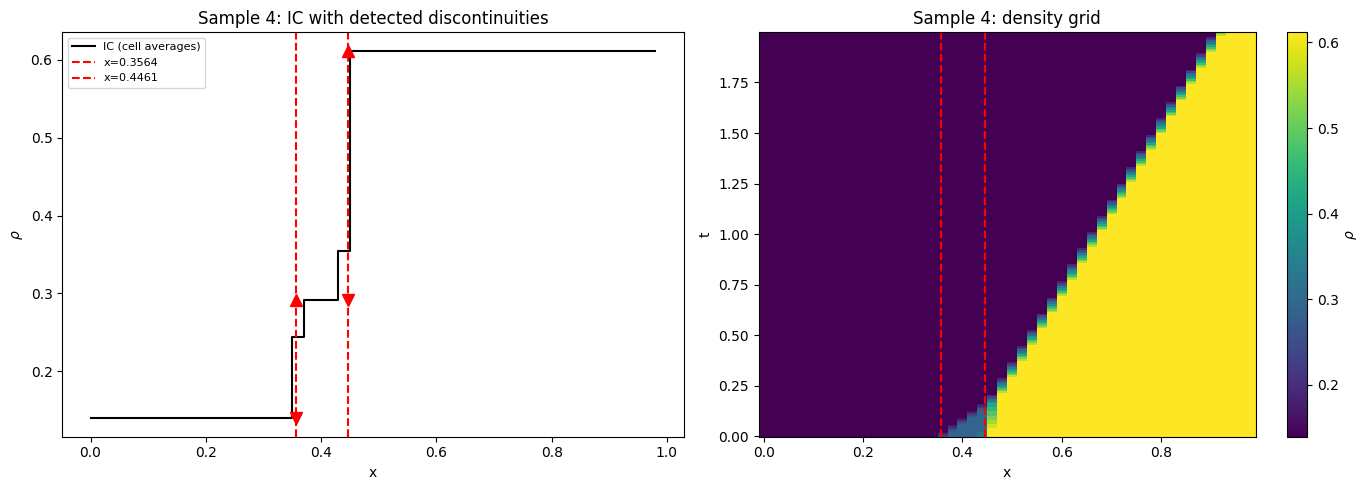

  disc 0: x=0.3564, left=0.1395, right=0.2921
  disc 1: x=0.4461, left=0.2921, right=0.6119


In [2]:
"""Cell 2: Plot each sample's grid with extracted discontinuity positions."""

x = np.arange(nx) * dx
t = np.arange(nt) * dt

for i, (input_data, target_grid) in enumerate(processed):
    grid = target_grid.squeeze(0).numpy()  # (nt, nx)
    ic_grid = grid[0, :]  # first time step

    # Extract discontinuities using the helper
    discs = _group_consecutive_diff_indices(ic_grid, dx, threshold=0.01)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Left: IC profile with detected discontinuity positions
    axes[0].step(x, ic_grid, where="mid", color="black", linewidth=1.5, label="IC (cell averages)")
    for d in discs:
        axes[0].axvline(d["x_pos"], color="red", linestyle="--", linewidth=1.5,
                        label=f'x={d["x_pos"]:.4f}')
        axes[0].plot(d["x_pos"], d["left_val"], "rv", markersize=8)
        axes[0].plot(d["x_pos"], d["right_val"], "r^", markersize=8)
    axes[0].set_xlabel("x")
    axes[0].set_ylabel(r"$\rho$")
    axes[0].set_title(f"Sample {i}: IC with detected discontinuities")
    axes[0].legend(fontsize=8)

    # Right: space-time grid with vertical lines at t=0 discontinuity positions
    im = axes[1].pcolormesh(x, t, grid, shading="auto", cmap="viridis")
    for d in discs:
        axes[1].axvline(d["x_pos"], color="red", linestyle="--", linewidth=1.5)
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("t")
    axes[1].set_title(f"Sample {i}: density grid")
    fig.colorbar(im, ax=axes[1], label=r"$\rho$")

    fig.tight_layout()
    plt.show()

    for j, d in enumerate(discs):
        print(f"  disc {j}: x={d['x_pos']:.4f}, left={d['left_val']:.4f}, right={d['right_val']:.4f}")